## Divy dataset example: HyperLogLog intersection support and dask computation

In [ ]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [1]:
import dask.dataframe as dd
import dask

In [2]:
from dask.distributed import Client, progress
client = Client()  # start distributed scheduler locally.  Launch dashboard on 8786

In [3]:
import matplotlib.pyplot as plt

In [4]:
import drac
from drac import HyperLogLog

### Get data
`kaggle datasets download -d yingwurenjian/chicago-divvy-bicycle-sharing-data`

In [5]:
# download dataset from kaggle.com, put it where you have access
ddf = dd.read_csv('/home/scott/bigbothd/divvy/data.csv',
                  dtype=object, 
                  blocksize='128MiB')

In [6]:
%time ddf.head()

CPU times: user 44.5 ms, sys: 18.4 ms, total: 62.9 ms
Wall time: 1.85 s


,trip_id,year,month,week,day,hour,usertype,gender,starttime,stoptime,...,from_station_id,from_station_name,latitude_start,longitude_start,dpcapacity_start,to_station_id,to_station_name,latitude_end,longitude_end,dpcapacity_end
0,2355134,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:57:00,2014-07-01 00:07:00,...,131,Lincoln Ave & Belmont Ave,41.939365,-87.668385,15.0,303,Broadway & Cornelia Ave,41.945512,-87.64598000000001,15.0
1,2355133,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:56:00,2014-07-01 00:00:00,...,282,Halsted St & Maxwell St,41.86458,-87.64693,15.0,22,May St & Taylor St,41.8694821,-87.6554864,15.0
2,2355130,2014,6,27,0,23,Subscriber,Male,2014-06-30 23:33:00,2014-06-30 23:35:00,...,327,Sheffield Ave & Webster Ave,41.921687,-87.65371400000001,19.0,225,Halsted St & Dickens Ave,41.919936,-87.64883,15.0
3,2355129,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:26:00,2014-07-01 00:24:00,...,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0,194,State St & Wacker Dr,41.887155,-87.62775,11.0
4,2355128,2014,6,27,0,23,Subscriber,Female,2014-06-30 23:16:00,2014-06-30 23:26:00,...,320,Loomis St & Lexington St,41.872187,-87.661501,15.0,134,Peoria St & Jackson Blvd,41.877749,-87.649633,19.0


In [9]:
%time ddf.trip_id.shape[0].compute()

CPU times: user 300 ms, sys: 32.1 ms, total: 332 ms
Wall time: 8.99 s


9495235

In [10]:
%time ddf.trip_id.nunique().compute()

CPU times: user 526 ms, sys: 31.6 ms, total: 558 ms
Wall time: 18 s


9495188

In [11]:
%time ddf.trip_id.nunique_approx().compute()

CPU times: user 330 ms, sys: 30.1 ms, total: 360 ms
Wall time: 10.7 s


9584730.548938287

### Parallel unique counting with hyperloglog

In [7]:
def hll_count_series(series):
    hll = drac.HyperLogLog()  # accept 1% counting error
    series.map( hll.add );
    return hll

In [8]:
res = ddf['trip_id'].map_partitions(hll_count_series, meta=('this_result','f8'))

In [9]:
res = res.to_delayed()

In [10]:
len(res)

16

In [11]:
def hll_reduce(x, y):
    x.update(y)
    return x

#### Tree reduction approach

In [12]:
L = res
while len(L) > 1:
    new_L = []
    for i in range(0, len(L), 2):
        lazy = dask.delayed(hll_reduce)(L[i-1], L[i])  # add neighbors  
        new_L.append(lazy)
    L = new_L                       # swap old list for new

In [13]:
%time len( dask.compute( *L )[0] )

CPU times: user 533 ms, sys: 35 ms, total: 568 ms
Wall time: 16.2 s


9570193

In [19]:
hll_res = dask.compute( *L )[0]

In [20]:
hll_res_0 = dask.compute( res[0] )[0].serialize()
hll_res_1 = dask.compute( res[1] )[0].serialize()

In [23]:
hll_res_1

'eJxkPQl8DdfXL3mzvz15iVBqi5aiqCA0KiWtZSyxlgqigiAlCIKUlLRIo4JYG0SlldZatUTFHvu+1RZFBUG0QbSpUt+5mTlzxv9rfuWamXvvuWffZpLMLZAsPhb232cZtdP4gXHxsQMz2ra6602umndiTJpPfIbqTPP5NKOTJTzNp1NGv4zaqqgK8D+vSvC/CH8q8G9e5eBvm2otv2aDKwL8my9/Tij/nyufJ5f/yw7/Esr/zevXreUz2NPshz0llc+STPOl8pFYfleEH20mVz4T92PQOOFPfJpdkQAeWzlUnL6ndk8uX0U7hVD+nLP8GtvNpj/D6XBp+3D6yvhvqRwKbR9B/5vT4RXLd+DgZNqTgvGDeBB0HPLlGNSeEfUrYvk+2rk1LGt7KuV/CzqWeZ0Ogj4SdYyJOn45E+ZFHS6CFmHiyuEU9fPhGbR1RH1/sRwntAunU0oqn4nwaZAKBhyyQR9ZhxzxLZXPYKtzOg9wBk0VnTqC/rek7yAZfCeU74sYFPRdbDq0SBFZh1Eo5xl7+Soaxjkde5JOQVGnAeJW0HlD1GnB9rDrtBP1k8iqoxx65Glb+S7aHM5EW7EcDns57QSdJwT9DEgNXsedqGNO1CFRDCpI5XuJJknAU2qYQRzh/ry+G+IH5VB5hQtxF+ILkgjEq4Znm4E7ST8lV45TSSWs8fq6sgEbr+sF4n2bzo+SLnGiPkPDqmRgXcMonZLTR6LpRMijsn5ejdJ2HULBOAv/ipxIOmfYdG6UTJDbyucp+qls5etKOpdK+j2XvhbqB8ngHnwWNZhoQIywi8Z9yTglb0gh8QHinzdwKRpX2XllAyPIGZwuEcjvtvI7sqETzDTndIySltV42K7rIlm/KuqUwX0VVTTox5fLg2hwEadrFNJ+bEWrLhu8sTuvQ0BShjqEMzBk3pesBG/ia9KwUvkVSYdZ1tdBTYH6H/mWdL9oaA3RwA1v6EtB10vSK5KG9BFM3CaUWxzkdNl

In [29]:
hll_empty = HyperLogLog(0.01)

In [30]:
hll_empty.__setstate__( HyperLogLog.deserialize(hll_res_0) )

In [31]:
hll_empty.k

SortedSet([68212472561497, 73925000420021, 80522207739778, 85522977043211, 86931337448449, 100429775376016, 209275222981081, 209379320728435, 269542651808245, 272191633065337, 273602444985899, 296956572541259, 320124233505549, 368751768956057, 383900932772255, 404232668642753, 432906042983141, 551784116153187, 585241044815507, 589622698271821, 593802653265191, 617625761528477, 702708316240812, 750265297240288, 818220131557604, 829964708291522, 860064423935864, 870167925519729, 885412800698917, 908434678568519, 928454994305924, 1050736401766774, 1065371659463202, 1086720445680158, 1100053267012015, 1157707423763917, 1201159702845172, 1231008551396390, 1240131974531118, 1266897712410056, 1334197784392432, 1346203853569871, 1398938594564253, 1430840485705120, 1441156722727881, 1464889496914871, 1531284424654477, 1569553701087434, 1620009991909992, 1677239591388295, 1749036952987414, 1758714626557807, 1760892470853875, 1775701640961297, 1837111425748408, 1842236262964190, 1852644346844128,

In [32]:
hll_empty_1 = HyperLogLog(0.01)
hll_empty_1.__setstate__( HyperLogLog.deserialize(hll_res_1) )

In [33]:
HyperLogLog.get_intersection_card( [hll_empty,hll_empty_1] )

0

In [34]:
def jaccard(ks):
    ks = [set(i) for i in ks]
    return len( set.intersection(*ks) ) / len( set.union(*ks) )

In [35]:
hll_empty.update(hll_empty_1)

In [36]:
hll_empty_1.update(hll_empty)

In [37]:
from random import sample
sample([1,2,3,4,5],3)

[3, 1, 2]

In [38]:
jaccard( [ hll_empty.k, hll_empty_1.k[:1024] ] )

0.015625

In [39]:
def get_max_card(x):
    return max([ hll.card() for hll in x])

In [40]:
max_card = get_max_card( [hll_empty, hll_empty_1] )

In [41]:
max_card

1206728.4372859586

In [42]:
def get_corrected_ks(x):
    max_card = get_max_card( x )
    return [ hll.k[:int(2048*hll.card()/max_card)] for hll in x  ]

In [43]:
corrected_ks = get_corrected_ks( [hll_empty, hll_empty_1] )

In [44]:
jaccard( corrected_ks )

1.0

In [45]:
def get_corrected_jaccard(x):
    return jaccard( get_corrected_ks(x) )

In [46]:
get_corrected_jaccard( [hll_empty, hll_empty_1] )

1.0

In [47]:
def get_intersection_card(x):
    hll_temp = HyperLogLog(0.01)
    [hll_temp.update(hll) for hll in x]
    return int( get_corrected_jaccard( x ) * hll_temp.card() )

In [48]:
get_intersection_card( [hll_empty, hll_empty_1] )

1206728

In [49]:
hll_empty.card()

1206728.4372859586

In [50]:
hll_empty_1.card()

1206728.4372859586

In [52]:
hll_empty_1 = HyperLogLog(0.01)

In [29]:
hll_empty_2 = HyperLogLog(0.01)

In [30]:
hll_empty_2.setstate_from_serialized( hll_res_1, return_len=True )

619104

In [26]:
hll_empty.update( *[hll_empty_1, hll_empty_2] )

In [27]:
hll_empty.card()

9570192.670578469

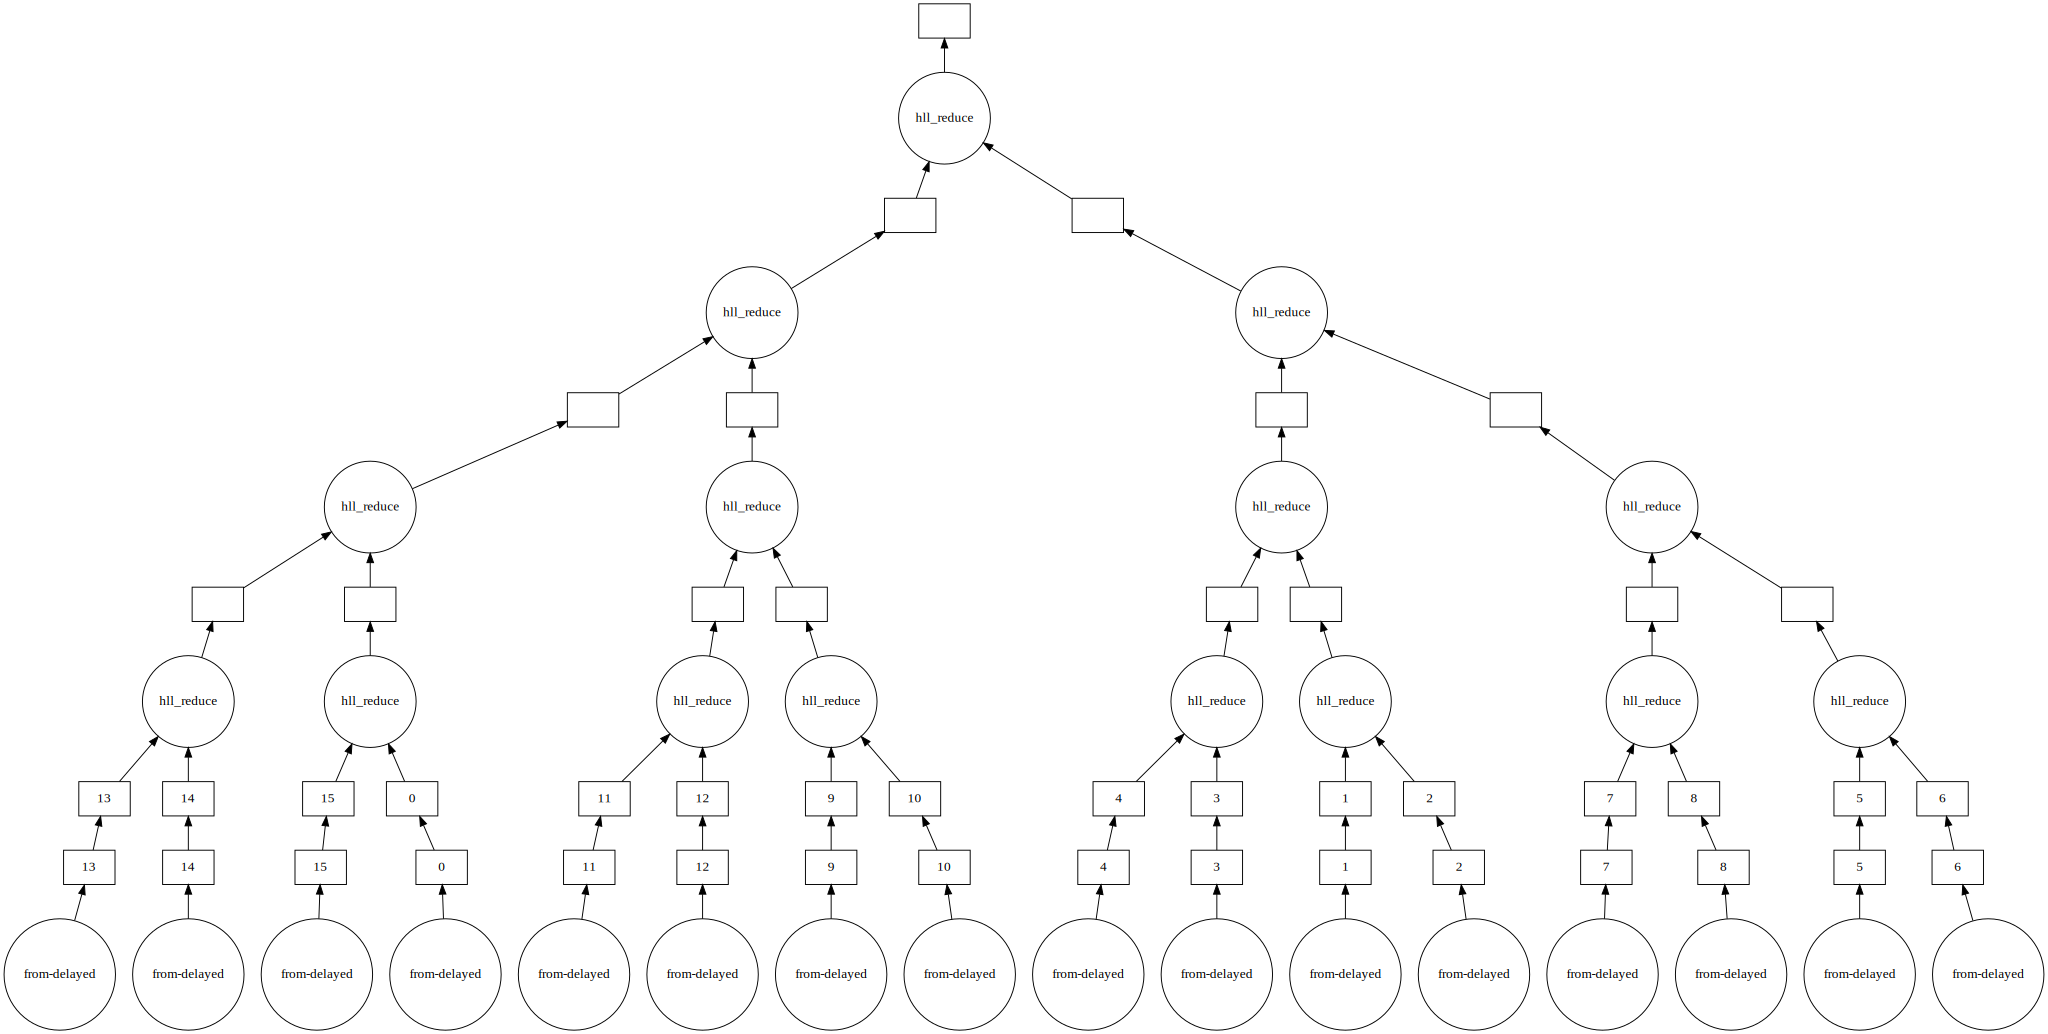

In [43]:
dask.visualize( *L, format='svg', filename='tree-reduce-graph' )

#### making a function

In [54]:
def get_tasks( res ):
    L = res.to_delayed()
    while len(L) > 1: # tree reduction
        new_L = []
        for i in range(0, len(L), 2):
            lazy = dask.delayed( hll_reduce )(L[i-1], L[i])  # add neighbors  
            new_L.append( lazy )
        L = new_L                       # swap old list for new
    return L

In [55]:
def hll_serialize(x):
    return x.serialize()

In [56]:
def get_serialized_hll( series ):
    '''returns serialized hll from dask series as dask delayed object'''
    res = series.map_partitions( hll_count_series , meta=('this_result','f8'))
    L = get_tasks(res)
    S = dask.delayed( hll_serialize )(L[0])
    #return dask.compute( *L )[0].serialize_registers()
    return S

In [57]:
%time hll_serial = get_serialized_hll( ddf['trip_id'] )#.compute()

CPU times: user 17.8 ms, sys: 3.78 ms, total: 21.6 ms
Wall time: 16.6 ms


In [58]:
%time len ( hll_serial.compute() )

CPU times: user 429 ms, sys: 50.4 ms, total: 479 ms
Wall time: 15.5 s


739128

#### custom groupbys

In [59]:
def groupby_approx_counts( ddf, x, countby='trip_id' ):
    '''
    input: takes in dask dataframe and item to group by, as well as item to count by
    output: tuple containing: list of unique values in the item to group by, a list of dask delayed objects with the serialized hll object
    '''
    results = []
    uniques = ddf[x].unique().compute().tolist()
    for value in uniques:
        results.append( get_serialized_hll( ddf[ ddf[x]==value ][countby] ) )
        
    serial_objs = dask.compute( *results )
    
    return x, uniques, serial_objs


    the knowledge_dict with hll creates "a data structure to store and explore"

In [60]:
knowledge_dict = {}

In [65]:
%time field, values, serial_objs = groupby_approx_counts( ddf, 'gender', countby='trip_id' )

CPU times: user 1.05 s, sys: 111 ms, total: 1.16 s
Wall time: 35.5 s


In [69]:
knowledge_dict[field] = {}
for i, val in enumerate( values ):
    knowledge_dict[field][val] = serial_objs[i]

In [70]:
%time field, values, serial_objs = groupby_approx_counts( ddf, 'month', countby='trip_id' )

CPU times: user 3.99 s, sys: 428 ms, total: 4.42 s
Wall time: 2min 4s


In [71]:
knowledge_dict[field] = {}
for i, val in enumerate( values ):
    knowledge_dict[field][val] = serial_objs[i]

In [72]:
knowledge_dict.keys()

dict_keys(['gender', 'month'])

In [73]:
knowledge_dict['month']['6']

'eJxkXQl8Ddf3f9vs7728JC8RW6WaElsbRIumlVbUMkEQRGsXxFJUg9gpLSJIK5ZqEERrCYJoY1dNNQiiDUK1RaNiq1BVKtX/uW/mzJn8/s2nXDNz7z333LN8z7lnJrMcywSL1cL+m54RnsYNGj0uaVBG+zY3vLPqHDg1Ps06LkN1p1nfy+hsiU6zds7olxGu8qoAP074m7UU+J+1ZN/fkiqqnO9fPPwt+loi/Mi+ZyT9efYjwv+S74fdlX29RN9TovGE5BtV8v3PwY8CPw7frKJvNpf+JGfqzenzSXo/Xn+G1+ljbQc8JemUSb4+vI8uWV8Lrz8v6uNJBkXaPU5/TtBXqMDfDr3FGWvD2WX9Cuvn9LUV/Q7vWxfOps0g6/0kgyrkK2u5dP4g5bxv7U7fv0RfH21dGm1OH18F35+cPoai+uk74/Td0yjy840k6fvIaHf75hD1eTUecL7/JV9v8/o0nrj0edkeOQyOI++dvifxCfY/8lnjP44h+bgp6DRy+nq1J0Wd46LvKUFfEf4v+K4qepv3Sahg9MN9FXQe8fpImmyJ+t5qnFYMOVT0v1G+SMbZNYeP905DBjU5kU1SqfFS1vfDZYyCMivr9Aj6arS1cIZUaCuUdQ0SfD00zjv0tWka5vSNjKvQZhUNDeJ0+RB0zeShN2oZjijr0i/4Vs35+sg+Cnhd0pDPpKeapiFfRBOVuIM4i6BzSfLtsGBQoz3NGfqg+OiRdYngdflF7vD63kmGfKB+a2uqaj1QX7Xddvm4z/nsAm+agTcolIw5NT3i9PFR4pASTWL9dB1wGVYC+/LGXkr6jnC67qBFkY31yLrl0PjDG/ukSQHyXdMDzR7IhgVFLmgS59S1glHghh/JJ5uKPpbDJN3II1716KvmdAnSxuN8VGnXnbqtk3SZxRkFnY+cvo9OXf6dhj3ldSuM0oJagD+oUSiVaGMEvY+k6wxnUM7rtod6CL550YpIqmDqw55061zndXo5Qz7

In [74]:
hll_test = HyperLogLog(0.01)

In [75]:
hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender']['Female']) )

In [76]:
hll_test_2 = HyperLogLog(0.01)
hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month']['7']) )

In [77]:
HyperLogLog.get_intersection_card( [hll_test, hll_test_2] )

360552

In [78]:
def get_min_card(x):
    return min( [ hll.card() for hll in x ] )

def containment(x):
    int_card = HyperLogLog.get_intersection_card(x)
    return [int_card / len(i) for i in x]

In [79]:
containment([hll_test, hll_test_2])

[0.15116641294217137, 0.2791739192378451]

In [80]:
HyperLogLog.get_corrected_jaccard([hll_test, hll_test_2])

0.10865771885734353

In [ ]:
# hll_test2 = HyperLogLog(0.01)
# hll_test2.setstate_from_serialized_list( [ knowledge_dict['month']['1']], 
#                                                   #knowledge_dict['month']['1'] ], 
#                                                 operation='or',
#                                                 return_len=True  )

In [81]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_int = HyperLogLog.get_intersection_card( [hll_test, hll_test_2] )
        data_list.append( [month, gender, card_int] )

In [83]:
df_inter = pd.DataFrame( data_list, columns=['month','gender','card estimate'] )
df_inter['month'] = df_inter['month'].astype(int)
df_inter = df_inter.sort_values(['month','gender']).reset_index(drop=True)
print( df_inter.to_markdown(tablefmt="github") )

|    |   month | gender   |   card estimate |
|----|---------|----------|-----------------|
|  0 |       1 | Female   |           51188 |
|  1 |       1 | Male     |          222455 |
|  2 |       2 | Female   |           59210 |
|  3 |       2 | Male     |          246677 |
|  4 |       3 | Female   |           93464 |
|  5 |       3 | Male     |          340408 |
|  6 |       4 | Female   |          141403 |
|  7 |       4 | Male     |          476394 |
|  8 |       5 | Female   |          212724 |
|  9 |       5 | Male     |          668272 |
| 10 |       6 | Female   |          321649 |
| 11 |       6 | Male     |          871597 |
| 12 |       7 | Female   |          360552 |
| 13 |       7 | Male     |          930521 |
| 14 |       8 | Female   |          356013 |
| 15 |       8 | Male     |          952413 |
| 16 |       9 | Female   |          313715 |
| 17 |       9 | Male     |          879395 |
| 18 |      10 | Female   |          246669 |
| 19 |      10 | Male     |       

In [84]:
%time ddf_gb = ddf.groupby(['month','gender'])['trip_id'].count().compute().reset_index()
ddf_gb['month'] = ddf_gb['month'].astype(int)
print(  ddf_gb.to_markdown(tablefmt="github") )

CPU times: user 271 ms, sys: 27.2 ms, total: 298 ms
Wall time: 8.77 s
|    |   month | gender   |   trip_id |
|----|---------|----------|-----------|
|  0 |       1 | Female   |     50003 |
|  1 |       1 | Male     |    221712 |
|  2 |       2 | Female   |     60649 |
|  3 |       2 | Male     |    245326 |
|  4 |       3 | Female   |     92346 |
|  5 |       3 | Male     |    345583 |
|  6 |       4 | Female   |    144702 |
|  7 |       4 | Male     |    476986 |
|  8 |       5 | Female   |    216973 |
|  9 |       5 | Male     |    652611 |
| 10 |       6 | Female   |    319679 |
| 11 |       6 | Male     |    858546 |
| 12 |       7 | Female   |    355774 |
| 13 |       7 | Male     |    923731 |
| 14 |       8 | Female   |    356374 |
| 15 |       8 | Male     |    948329 |
| 16 |       9 | Female   |    314032 |
| 17 |       9 | Male     |    875939 |
| 18 |      10 | Female   |    244807 |
| 19 |      10 | Male     |    752905 |
| 20 |      11 | Female   |    145102 |
| 21 |    

In [85]:
df_merge = df_inter.merge( ddf_gb, on=['month','gender'] ).rename(columns={'trip_id':'card actual'})
df_merge['percent diff'] = 100*(df_merge['card actual'] - df_merge['card estimate'])/ df_merge['card actual']
df_merge['percent diff'] = df_merge['percent diff'].round(2).map(lambda x:str(x)+'%')
print( df_merge.to_markdown(tablefmt="github") )

|    |   month | gender   |   card estimate |   card actual | percent diff   |
|----|---------|----------|-----------------|---------------|----------------|
|  0 |       1 | Female   |           51188 |         50003 | -2.37%         |
|  1 |       1 | Male     |          222455 |        221712 | -0.34%         |
|  2 |       2 | Female   |           59210 |         60649 | 2.37%          |
|  3 |       2 | Male     |          246677 |        245326 | -0.55%         |
|  4 |       3 | Female   |           93464 |         92346 | -1.21%         |
|  5 |       3 | Male     |          340408 |        345583 | 1.5%           |
|  6 |       4 | Female   |          141403 |        144702 | 2.28%          |
|  7 |       4 | Male     |          476394 |        476986 | 0.12%          |
|  8 |       5 | Female   |          212724 |        216973 | 1.96%          |
|  9 |       5 | Male     |          668272 |        652611 | -2.4%          |
| 10 |       6 | Female   |          321649 |       

In [86]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_int = HyperLogLog.get_corrected_jaccard( [hll_test, hll_test_2] )
        data_list.append( [month, gender, card_int] )

In [87]:
df_jac = pd.DataFrame( data_list, columns=['month','gender','jaccard'] )
df_jac['month'] = df_jac['month'].astype(int)
df_jac = df_jac.sort_values(['month','gender']).reset_index(drop=True)
print( df_jac.to_markdown(tablefmt="github") )

|    |   month | gender   |   jaccard |
|----|---------|----------|-----------|
|  0 |       1 | Female   | 0.0195769 |
|  1 |       1 | Male     | 0.0305427 |
|  2 |       2 | Female   | 0.0225975 |
|  3 |       2 | Male     | 0.0338727 |
|  4 |       3 | Female   | 0.0343767 |
|  5 |       3 | Male     | 0.0465813 |
|  6 |       4 | Female   | 0.049611  |
|  7 |       4 | Male     | 0.0646073 |
|  8 |       5 | Female   | 0.0703103 |
|  9 |       5 | Male     | 0.0898733 |
| 10 |       6 | Female   | 0.0986965 |
| 11 |       6 | Male     | 0.115376  |
| 12 |       7 | Female   | 0.108658  |
| 13 |       7 | Male     | 0.123034  |
| 14 |       8 | Female   | 0.107252  |
| 15 |       8 | Male     | 0.125493  |
| 16 |       9 | Female   | 0.0963458 |
| 17 |       9 | Male     | 0.116381  |
| 18 |      10 | Female   | 0.078411  |
| 19 |      10 | Male     | 0.101663  |
| 20 |      11 | Female   | 0.0491236 |
| 21 |      11 | Male     | 0.0691405 |
| 22 |      12 | Female   | 0.0284407 |


In [88]:
df_jac_gb = df_jac.groupby( 'gender' ).agg( {'jaccard':'sum'} )
df_jac_gb / df_jac_gb.sum()

,jaccard
gender,
Female,0.44283
Male,0.55717


In [89]:
df_jac_gb = df_jac.groupby( 'month' ).agg( {'jaccard':'sum'} )
(df_jac_gb / df_jac_gb.sum())

,jaccard
month,
1,0.029073
2,0.032757
3,0.046962
4,0.066255
5,0.092919
6,0.124178
7,0.134399
8,0.135010
9,0.123398


In [90]:
data_list = []

for month in knowledge_dict['month']:
    for gender in knowledge_dict['gender']:
        hll_test = HyperLogLog(0.01)
        hll_test.__setstate__( HyperLogLog.deserialize(knowledge_dict['gender'][gender]) )
        card_1 = len( hll_test )
        hll_test_2 = HyperLogLog(0.01)
        hll_test_2.__setstate__( HyperLogLog.deserialize(knowledge_dict['month'][month]) )
        card_2 = len( hll_test_2 )
        hll_test.update( hll_test_2 )
        card_int = len(hll_test)
        data_list.append( [month, gender, card_1, card_2, card_int] )

In [91]:
df_card = pd.DataFrame( data_list, columns=['month','gender','card_gender','card_month','card_union'] )
df_card['month'] = df_card['month'].astype(int)
df_card['card_int'] = df_card['card_gender'] + df_card['card_month'] - df_card['card_union']
df_card = df_card.sort_values(['month','gender']).reset_index(drop=True)
print( df_card.to_markdown(tablefmt="github") )

|    |   month | gender   |   card_gender |   card_month |   card_union |   card_int |
|----|---------|----------|---------------|--------------|--------------|------------|
|  0 |       1 | Female   |       2385133 |       274193 |      2614730 |      44596 |
|  1 |       1 | Male     |       7225758 |       274193 |      7283434 |     216517 |
|  2 |       2 | Female   |       2385133 |       312568 |      2620227 |      77474 |
|  3 |       2 | Male     |       7225758 |       312568 |      7282500 |     255826 |
|  4 |       3 | Female   |       2385133 |       441290 |      2718832 |     107591 |
|  5 |       3 | Male     |       7225758 |       441290 |      7307849 |     359199 |
|  6 |       4 | Female   |       2385133 |       624772 |      2850239 |     159666 |
|  7 |       4 | Male     |       7225758 |       624772 |      7373695 |     476835 |
|  8 |       5 | Female   |       2385133 |       874166 |      3025513 |     233786 |
|  9 |       5 | Male     |       7225758 |

In [92]:
df_merge_2 = df_card.merge( ddf_gb, on=['month','gender'] ).rename(columns={'trip_id':'card actual'})
df_merge_2['perc diff'] = 100*(df_merge_2['card actual'] - df_merge_2['card_int'])/ df_merge_2['card actual']
df_merge_2['perc diff'] = df_merge_2['perc diff'].round(2).map(lambda x:str(x)+'%')
print( df_merge_2[['month','gender','card_int','card actual','perc diff']].to_markdown(tablefmt="github") )

|    |   month | gender   |   card_int |   card actual | perc diff   |
|----|---------|----------|------------|---------------|-------------|
|  0 |       1 | Female   |      44596 |         50003 | 10.81%      |
|  1 |       1 | Male     |     216517 |        221712 | 2.34%       |
|  2 |       2 | Female   |      77474 |         60649 | -27.74%     |
|  3 |       2 | Male     |     255826 |        245326 | -4.28%      |
|  4 |       3 | Female   |     107591 |         92346 | -16.51%     |
|  5 |       3 | Male     |     359199 |        345583 | -3.94%      |
|  6 |       4 | Female   |     159666 |        144702 | -10.34%     |
|  7 |       4 | Male     |     476835 |        476986 | 0.03%       |
|  8 |       5 | Female   |     233786 |        216973 | -7.75%      |
|  9 |       5 | Male     |     664212 |        652611 | -1.78%      |
| 10 |       6 | Female   |     320897 |        319679 | -0.38%      |
| 11 |       6 | Male     |     866065 |        858546 | -0.88%      |
| 12 |